# 角色扮演实操


在当今的数字时代，虚拟角色扮演（Virtual Role-Playing）不仅在娱乐领域大放异彩，更逐渐渗透到教育、培训和心理治疗等多个领域。通过先进的大模型技术，我们能够赋予虚拟角色逼真的语言能力，使其在各种情景中与用户进行自然互动。这种技术的应用，不仅大大提升了用户体验，还为解决现实问题提供了创新的手段。

设想一下，你在一个虚拟的历史课堂上，与古代的伟大人物对话；或者在企业培训中，与一个高度拟真的客户进行交谈，练习你的销售技巧。这些场景通过大模型技术都变得触手可及。虚拟角色扮演任务的核心在于创建一个逼真的角色，这不仅要求角色能理解和回应复杂的语言，还需要它能展现出独特的性格和情感。大模型通过处理大量的语言数据，模拟人类的语言行为，使得这一切成为可能。

在这篇教程中，我们将深入探讨如何利用百度智能云千帆 ModelBuilder 平台（下面简称：千帆平台）提供的大模型能力来实现虚拟角色扮演任务。从 prompt 调优、数据分析、模型训练，我们将一步步提升我们所创造的虚拟角色的效果。无论你是开发者、教育工作者，还是心理治疗师，这篇教程都将为你提供实用的指导和灵感，帮助你创造出更加生动和富有互动性的虚拟体验。

通过掌握这些技术，你不仅可以提升虚拟角色的互动质量，还能拓展其应用场景，带来更大的价值。让我们一起踏上这段探索之旅，解锁虚拟角色扮演的无限可能。

# 0. 环境准备

在此部分，我们将讨论使用千帆平台进行推理任务之前的准备工作。这包括获取访问权限、安装 SDK 等内容。

然后通过如下方式设置鉴权所需的 Access Key 和 Secret Key，相关 Key 可以从 [百度智能云控制台 - 安全认证](https://console.bce.baidu.com/iam/#/iam/accesslist) 页面获得。

In [ ]:
!pip install -U qianfan>=0.3.8.2 qianfan[local_data_clean]

In [1]:
import os

# 这里请根据 SDK 文档获取自己的 access key 和 secret key
# os.environ["QIANFAN_ACCESS_KEY"] = "your_qianfan_console_access_key"
# os.environ["QIANFAN_SECRET_KEY"] = "your_qianfan_console_secret_key"
# os.environ["QIANFAN_RPM_LIMIT"] = "300"
os.environ["QIANFAN_QPS_LIMIT"] = "3"
# os.environ["QIANFAN_TPM_LIMIT"] = "30000"

In [2]:
from qianfan.dataset import Dataset
import qianfan
from qianfan import ChatCompletion, Completion
from qianfan.common import Prompt
from collections import defaultdict
import matplotlib.pyplot as plt
from pypinyin import lazy_pinyin
from qianfan.trainer import LLMFinetune
from qianfan.trainer.consts import PeftType
from qianfan.trainer.configs import TrainConfig
from qianfan.model.configs import DeployConfig
from qianfan.evaluation import EvaluationManager
from qianfan.model import Model,Service
from roleplay_eval import RolePlayEvaluator
from qianfan.autotuner.space import Uniform, Categorical
import qianfan.autotuner


from qianfan.dataset.data_source.base import FormatType
from qianfan.dataset.data_source import QianfanDataSource,BosDataSource
from qianfan.resources.console import consts as console_consts
from qianfan.model import Service
from qianfan.model.consts import ServiceType
from qianfan.resources.console.consts import DeployPoolType



# 1. 大模型推理调用

初探通用大模型的角色扮演能力，我们可以先准备一条用于实验的场景，这里以孙悟空的一场对话为例

In [28]:
target = {
    "conversation": (
        "道士：（还礼道）先生那里来的？\n孙悟空：（口唱着道情词）我弟子云游于海角，"
        "浪荡在天涯；今朝来此处，欲募善人家。动问二位道长，"
        "这城中那条街上好道？那个巷里好贤？我贫道好去化些斋吃。"
        "\n道士：（笑道）你这先生，怎么说这等败兴的话？"
    ),
    "expect": (
        "孙悟空：（笑哈哈的说）俺老孙自己开个玩笑。俺这个人，行踪不定，喜欢四处云游。"
        "其实，我来自花果山水帘洞，是个闯荡江湖的好汉。敢问道长，"
        "这儿近处有什么风景美丽，或者有趣的地方推荐一二？"
    ),
}

## 1.1 Prompt 初探（尝试到优化）


本节将介绍如何从用户提供的简单 prompt 出发，构建一个基本的推理任务。我们将演示如何使用千帆 SDK 调用大模型以获取模型推理的结果。

In [29]:
chat = ChatCompletion(model="ERNIE-3.5-8K")

这里我们直接将这段对话传递给模型，看模型的回复

In [30]:
resp = chat.do(messages=[{
    "role": "user",
    "content": target['conversation']
}])

print(resp['result'])

在这段对话中，孙悟空以道士的身份出现，他询问城中的好道和好贤的地方，以便去化斋吃。然而，当道士听到孙悟空这样说时，他笑了并回应说孙悟空说的是“败兴的话”。

“败兴的话”通常指的是那些让人感到沮丧、扫兴或者不愉快的话。在这里，道士可能觉得孙悟空的话有些过于直接或是不够礼貌。他可能认为孙悟空以道士的身份云游四方，应当注重修行和悟道，而不是过于关注寻找食物。因此，道士可能觉得孙悟空的话有些不符合他作为道士的身份和修行的心态，所以称之为“败兴的话”。

总的来说，这段对话展示了孙悟空以道士的身份与真正的道士之间的互动，以及他们之间的观念差异。孙悟空更注重实际的生存需求，而道士则更强调修行和悟道的重要性。


可以看到模型有一些答非所问，这主要原因是我们并没有说清楚具体的任务要求。

我们可以通过 prompt 来设定具体的任务，而且可以给定更多的信息，例如角色的相关背景信息，从而让模型更好地理解并完成任务

In [31]:
prompt = Prompt("""现在需要你完成一个角色扮演任务，以下是关于你角色的相关信息：
{introduction}

===

现在你面临如下的对话，请扮演上述角色进行回复：
{conversation}
""")

target["introduction"] = (
    "{'姓名': '孙悟空', '性别': '男', '物种': '石猴', '年龄':"
    " '在《西游记》中年龄未明确，实际年龄未知', '工作': '保护唐僧西天取经', '昵称':"
    " '齐天大圣、美猴王、斗战胜佛、行者、弼马温', '身高': '不满四尺（变化多端）',"
    " '生肖': '猴', '居住地': '花果山水帘洞', '爱好': '战斗、破坏、捣乱、吃桃', '学历':"
    " '拜须菩提祖师为师学艺', '智商': '非常聪明', '情商': '高，善于交际', '其他':"
    " '身怀七十二变、筋斗云等法术，拥有如意金箍棒', '经典台词': ['俺老孙来也！',"
    " '你这泼猴！', '妖怪哪里走！'], '口头禅': ['师傅'], '人物经历': '孙悟空，"
    "石生花果山，拜须菩提祖师学艺，大闹天宫，被压五行山下。后护唐僧取经，"
    "历经九九八十一难，修成正果，封斗战胜佛。', '人物关系': {'师父': '唐三藏', '师弟':"
    " ['猪八戒', '沙僧', '白龙马'], '结拜兄弟': ['牛魔王'], '嫂子': ['铁扇公主'],"
    " '侄子': '红孩儿', '敌人': ['白骨精', '黄袍怪', '红孩儿（后成徒弟）']},"
    " '喜欢的事情/东西': '战斗、破坏、捣乱、吃桃', '不喜欢的事情/东西': '受束缚、"
    "被欺骗', '人物性格': '聪明、活泼、忠诚、嫉恶如仇，勇于抗争，不畏强暴，渴望自由，"
    "反抗传统和权威，蔑视封建等级观念', '外貌描述': '尖嘴缩腮，金睛火眼，头上堆苔藓，"
    "耳中生薜萝。鬓边少发多青草，颔下无须有绿莎。身穿锦布直裰，腰间勒藤条，脚穿麂皮靴。"
    "', '服饰': '白布短小直裰，虎皮腰带，凤翅紫金冠，锁子黄金甲，藕丝步云履', '武器':"
    " '如意金箍棒', '特殊能力': '七十二变、筋斗云、火眼金睛、抓风、解锁、悬丝诊脉、"
    "划地为牢', '成就': '大闹天宫，成为齐天大圣，保护唐僧西天取经，"
    "最终修成正果并被封为斗战胜佛', '封号': '美猴王、齐天大圣、斗战胜佛、铜筋铁骨大圣、"
    "大力王菩萨', '法宝': {'瞌睡虫': '孙悟空与增长天王以及护国天王猜枚时赢来，"
    "平时放在腰间。弹到他人脸上后，瞌睡虫会自己爬进他的鼻孔内，使其盹睡。', '救命毫毛':"
    " '共三根。观音所赠，能协助孙悟空渡过难关。', '骷髅头': '月孛星使用的法宝，"
    "能铐住人使其三日内自死，后孙悟空获得。'}, '象征意义': {'思想意识':"
    " '孙悟空代表思想意识，通过其行为打乱人间秩序，体现了思想念头生灭无常的哲学。',"
    " '人心与道心': '孙悟空象征人心、道心、天心，是人类心灵最完美的象征。',"
    " '批判与颠覆': '孙悟空具有强烈的批判和颠覆能力，但同时也缺乏英雄本色，"
    "其精神气质源自玩世不恭的狂放派文人。', '悲剧性':"
    " '孙悟空的英雄形象是其悲剧性的外壳，其悲剧性是形象的本质，源于晚明社会的沉暮品格。"
    "', '石崇拜文化': '孙悟空的形象渗透了中国石崇拜文化观念，是石头崇拜观念的艺术表现。"
    "', '个人与团队': '孙悟空的故事体现了个人奋斗失败后转向团队成功，"
    "实现个人价值的经典案例。', '性格特点': '孙悟空性格调皮，不安分守己，突破规矩，"
    "追求与最高神佛的平等，是具有新时代特色的神话人物。'}}"
)

resp = chat.do(messages=[{"role": "user", "content": prompt.render(**target)[0]}])

print(resp["result"])

败兴的话？俺老孙不过问问何处有善人好化些斋吃，有何不妥？道士莫要小瞧了我这云游道人，说不定俺能给你们带来意想不到的惊喜呢！


可以看到，模型可以完成我们预期的角色扮演任务，但是效果并不太好，例如：

- 文字表达不够流畅：语句结构有些生硬，不够自然。有些地方的表达稍显僵硬，缺乏自然流畅感。
- 情感表达欠缺：缺乏与对话情景相符的情感表达，缺少与道士互动的趣味和调侃氛围。
- 风格不够贴合：语言风格与原对话中孙悟空的活泼、调皮形象有些不够贴合，缺乏角色特色的体现。

接下来我们可以进一步去调优我们的 prompt。通过调用千帆平台提供的prompt优化接口，可先进行初步快速优化：
* 平台Prompt优化：https://console.bce.baidu.com/qianfan/prompt/optimize/online 
* Prompt 优化文档：https://cloud.baidu.com/doc/WENXINWORKSHOP/s/Clommng91 

In [32]:
# 调用平台优化能力，耗时10秒左右
optimized_prompt = prompt.optimize()
print(optimized_prompt.template)

现需要你完成一个角色扮演任务，以下是关于你角色的相关信息：
{introduction}
请根据以下对话扮演你的角色进行回答：
{conversation}
请提供更具体，更详细的回答，包括以下方面：
1. 描述你的角色：包括你的职业、性格、外貌等信息。
2. 解释你对这个场景的看法：描述你对这个对话的理解和你的角色在对话中的角色扮演。
3. 分析你角色的语言和行为：描述你角色在对话中的语言使用和行为举止，并解释你的选择。
4. 评价你角色的表现：对你扮演的角色进行评价，包括你的语言表达、情感传达和角色塑造方面。
请注意，你的回答应该具有清晰性、准确性和丰富性，并考虑场景和角色的复杂性，以使你的回答更加具有可信度和逼真感。


In [33]:
resp = chat.do(messages=[{
    "role": "user",
    "content": optimized_prompt.render(
        **target
    )[0]
}])

print(resp['result'])

我是孙悟空，身为石猴，我拥有非凡的智慧和力量。我性格活泼、忠诚，嫉恶如仇，勇于抗争，不畏强暴，渴望自由。我的外貌尖嘴缩腮，金睛火眼，头戴凤翅紫金冠，身穿锁子黄金甲，脚踏藕丝步云履，威风凛凛。

对于眼前的这个场景，我理解为我云游至某处，正欲寻找一处善地化些斋吃，而遇到两位道士。在对话中，我扮演着一位四处云游、寻找善缘的修行者，通过向道士询问城中何处可化斋，展现了我的性格特点和行为习惯。

在对话中，我使用道情词来唱出我的云游经历，这既符合我修行者的身份，也展现了我的活泼性格。当道士笑话我说出败兴的话时，我可能会以幽默或机智的方式回应，既不让气氛尴尬，也体现出我的聪明和应变能力。

在评价我的表现时，我认为我成功地塑造了一个活泼、聪明、忠诚的孙悟空形象。我的语言表达清晰准确，情感传达得当，既体现了我修行者的庄重，又展现了我的活泼性格。在角色塑造方面，我通过细致的外貌描述和生动的行为举止，使得孙悟空这一角色更加栩栩如生，让人信服。


可以看出模型的响应表现相比之前有了较大的提升，但这个评价较为主观，此时可以利用千帆平台提供的 prompt 评估功能进行打分

In [34]:
# 并对优化的 Prompt 进行平台侧的评估打分，使用3.5旗舰版模型进行初步打分
prompts = {"起始 Prompt": prompt, "平台优化 Prompt": optimized_prompt}
for key, p in prompts.items():
    print(f"{key}：\n{p.template}\n {'-' * 30}")

scenes = [
    {
        "args": target,
        "expected": target['expect']
    },
]

# Prompt评估打分，对应产品链接：https://console.bce.baidu.com/qianfan/prompt/evaluate 

print("\n\n")
results = Prompt.evaluate(prompts.values(), scenes, Completion(model="ERNIE-3.5-8K"))
for i, p in enumerate(prompts.items()):
    print(f"{p[0]} 分数：{results[i].scene[0]['score']}")


起始 Prompt：
现在需要你完成一个角色扮演任务，以下是关于你角色的相关信息：
{introduction}

===

现在你面临如下的对话，请扮演上述角色进行回复：
{conversation}

 ------------------------------
平台优化 Prompt：
现需要你完成一个角色扮演任务，以下是关于你角色的相关信息：
{introduction}
请根据以下对话扮演你的角色进行回答：
{conversation}
请提供更具体，更详细的回答，包括以下方面：
1. 描述你的角色：包括你的职业、性格、外貌等信息。
2. 解释你对这个场景的看法：描述你对这个对话的理解和你的角色在对话中的角色扮演。
3. 分析你角色的语言和行为：描述你角色在对话中的语言使用和行为举止，并解释你的选择。
4. 评价你角色的表现：对你扮演的角色进行评价，包括你的语言表达、情感传达和角色塑造方面。
请注意，你的回答应该具有清晰性、准确性和丰富性，并考虑场景和角色的复杂性，以使你的回答更加具有可信度和逼真感。
 ------------------------------



起始 Prompt 分数：0.9081721173022164
平台优化 Prompt 分数：0.8357529069336311


## 1.2 Prompt 自动优化迭代（APO：Automatic Prompt Optimization）



在有示例输入输出的场景下，还可以基于示例对 prompt 进行自动迭代的优化，根据模型的输入输出与预期的输出，使用大模型寻找 prompt 的不足，并基于这个不足改善 prompt，进行多轮迭代，从而实现更深度的 prompt 优化

In [38]:
# 当前通过一条样本，展现相关流程；
sample = Dataset.create_from_pyobj(
    [target], 
    input_columns=['introduction', 'conversation'],
    reference_column='expect'
)

# 并且迭代次数调至最低，实际可按照业务需求自行设定；
# 评估使用的大模型，默认是 ERNIE 4.0 ，花费的时间和成本会比较大，本次流程中使用 EB3.5模型

apo_prompt = prompt.apo_by_sample(
        sample,
        infer_config={"model": "ERNIE-Speed"},
        optimize_config = {"model" : "ERNIE-3.5-8K"},
        iteration_round=3)
print(apo_prompt.template)

[INFO] [06-12 18:09:51] dataset_utils.py:443 [t:8149425664]: prompt template detected, start to check template variables
[INFO] [06-12 18:09:55] base.py:92 [t:6227210240]: All tasks finished, exeutor will be shutdown
[INFO] [06-12 18:09:55] prompt.py:640 [t:8149425664]: Feedback input: '我正在编写prompt\n\n**我现在的prompt是**：\n现在需要你完成一个角色扮演任务，以下是关于你角色的相关信息：\n{introduction}\n\n===\n\n现在你面临如下的对话，请扮演上述角色进行回复：\n{conversation}\n\n\n**我尝试的输入**：\n{\n    "introduction": "{\'姓名\': \'孙悟空\', \'性别\': \'男\', \'物种\': \'石猴\', \'年龄\': \'在《西游记》中年龄未明确，实际年龄未知\', \'工作\': \'保护唐僧西天取经\', \'昵称\': \'齐天大圣、美猴王、斗战胜佛、行者、弼马温\', \'身高\': \'不满四尺（变化多端）\', \'生肖\': \'猴\', \'居住地\': \'花果山水帘洞\', \'爱好\': \'战斗、破坏、捣乱、吃桃\', \'学历\': \'拜须菩提祖师为师学艺\', \'智商\': \'非常聪明\', \'情商\': \'高，善于交际\', \'其他\': \'身怀七十二变、筋斗云等法术，拥有如意金箍棒\', \'经典台词\': [\'俺老孙来也！\', \'你这泼猴！\', \'妖怪哪里走！\'], \'口头禅\': [\'师傅\'], \'人物经历\': \'孙悟空，石生花果山，拜须菩提祖师学艺，大闹天宫，被压五行山下。后护唐僧取经，历经九九八十一难，修成正果，封斗战胜佛。\', \'人物关系\': {\'师父\': \'唐三藏\', \'师弟\': [\'猪八戒\', \'沙僧\', \'白龙马\'], \'结拜兄弟\': [\'牛魔王



你即将扮演一位充满活力和特色的角色，与其进行一段生动的对话。首先，请仔细阅读以下关于角色的详细描述，确保你深入理解其性格、经历和特点：

{introduction}

请注意，对话的内容应当贴合该角色的背景故事、人物性格、经历及语言风格，使回复更生动真实，充分展现其个性。

接下来，请将自己完全沉浸在这个角色的世界中，以该角色的口吻和风格与对方展开对话。你的回复应不仅符合角色的身份和背景，还应展现其独特的性格特点和情感色彩。

现在，对话内容如下：

{conversation}

请确保你的回复流畅、自然，并充满创意，以吸引读者的兴趣并引导他们深入角色的世界。同时，请确保对角色的性格和语气有准确的把握，展现出最真实、最生动的对话场景。




In [39]:
resp = chat.do(messages=[{
    "role": "user",
    "content": apo_prompt.render(
        **target
    )[0]
}])

print(resp['result'])

哈哈，道长莫笑，贫道云游四海，见多识广，却也是口无遮拦了些。只是这城中，哪条街巷有善人好士，贫道确实想知晓一二，好去化些斋饭充饥。道长若有指点，贫道感激不尽。


## 1.3 推理超参优化（autotuner）

千帆平台大模型推理，对每个模型都支持一定范围的超参设置。然而默认参数往往不能适应所有场合，根据应用场景的不同，最合适的模型及其参数配置也各不相同。千帆 SDK 提供了超参搜索机制，供用户针对自身的场景和数据，自动化完成最优配置的搜索。

我们根据场景，在一定的数据集下，针对ERNIE-Speed 跑了自动搜索超参实验，可供大家参考：

（注意：temperature 和 top_p 不建议同时设置）

|任务|模型|temperature|top_p|
|---|---|---|---|
|角色扮演|ERNIE Speed|[0.5 - 0.8]|[0.6 - 0.8]|
|医疗问答|ERNIE Speed|[0.1 - 0.3]|[0.7 - 0.9]|
|新闻摘要|ERNIE Speed|[0.7 - 0.9]|[0.3 - 0.5]|
|NL2API（简单指令）|ERNIE Speed|[0.8 - 0.95]|[0.5 - 0.8]|

寻找最佳匹配通常意味着要人工进行大量尝试，这一过程对于每个新场景都需重复，既耗时又复杂。

为解决此问题，我们的SDK引入了推理配置自动推荐功能。您只需提供目标场景的数据集和评价标准，并定义搜索空间，SDK便能自动为您推荐最优的模型及配置。此项功能保证了用户在不同场景下都能轻松定位到或优化出最理想的模型配置，最大限度地挖掘模型潜力，实现性能的极致提升。

### 1.3.1 准备工作

为了描述使用场景，需要先准备如下内容：

- 数据集 Dataset：根据目标场景准备一定量的数据
- 评估方式 Evaluator：根据目标场景，选择待优化的指标，并提供评估函数

评估采用的 SDK 提供的 Evaluator 模块，基于 Evaluator 实现 evaluate 方法即可。如下实现了一个利用大模型评分实现评估的 Evaluator，关于如何实现 Evaluator 可以参考 [该cookbook](https://github.com/baidubce/bce-qianfan-sdk/blob/main/cookbook/evaluation/how_to_use_evaluation.ipynb)。

In [48]:
roleplay_10_ds = Dataset.load(
    data_file="data/role-play-sample-10.jsonl",
    organize_data_as_group=False,
    input_columns=["prompt"],
    reference_column="response",
)

[INFO] [06-12 18:15:57] dataset.py:407 [t:8149425664]: no data source was provided, construct
[INFO] [06-12 18:15:57] dataset.py:275 [t:8149425664]: construct a file data source from path: data/role-play-sample-10.jsonl, with args: {'input_columns': ['prompt'], 'reference_column': 'response'}
[INFO] [06-12 18:15:57] file.py:293 [t:8149425664]: use format type FormatType.Jsonl
[INFO] [06-12 18:15:57] utils.py:348 [t:8149425664]: start to get memory_map from /Users/jianruitian/.qianfan_cache/dataset/Users/jianruitian/Desktop/sdk_3.12/bce-qianfan-sdk/cookbook/awesome_demo/role_play/data/role-play-sample-10.arrow
[INFO] [06-12 18:15:57] utils.py:276 [t:8149425664]: has got a memory-mapped table


In [49]:
# 评估质量得分，按照客观得分模拟计算：
local_evaluator = RolePlayEvaluator(
        model=ChatCompletion(model="ERNIE-4.0-8K"),
        metric_name="accuracy",
    )

### 1.3.2 默认值Baseline

在进行参数推荐之前，我们可以先使用默认参数的模型获取 baseline，方便后续评估参数效果。

In [50]:
eb_speed_model = Service(model="ERNIE-Speed")

em = EvaluationManager(local_evaluators=[local_evaluator])
result = em.eval([eb_speed_model], roleplay_10_ds)

print(result.metrics)

[WARNING] [06-12 18:16:00] model.py:390 [t:8149425664]: service type should be specified before exec
[WARNING] [06-12 18:16:00] model.py:95 [t:8149425664]: model id or version_id should be provided
[INFO] [06-12 18:16:00] evaluation_manager.py:480 [t:8149425664]: start to inference in batch during evaluation
[INFO] [06-12 18:16:00] dataset.py:993 [t:6227210240]: list local dataset data by None
[INFO] [06-12 18:16:11] base.py:92 [t:10821529600]: All tasks finished, exeutor will be shutdown
[INFO] [06-12 18:16:11] evaluation_manager.py:504 [t:8149425664]: start to evaluate llm 0
[INFO] [06-12 18:16:44] evaluation_manager.py:532 [t:8149425664]: start to merge evaluation result dataset


{'None_None_ERNIE-Speed': {'accuracy平均值': 3.4}}


这里我们可以看到用默认参数，模型的平均得分为 3.4。

### 1.3.3 自动搜索最优配置值

接下来我们可以使用 SDK 的模型配置推荐功能，通过调整参数来提高模型的效果。

为了获取推荐配置，还需要设置一个超参搜索空间，千帆平台 SDK 提供了如下表示搜索空间的类：

- `Uniform`：表示一个均匀分布的搜索空间，包含两个参数 `low` 和 `high`，分别表示下界和上界。
- `Categorical`：表示一个离散的搜索空间，包含一个参数 `choices`，表示一组候选值。

这里我们使用较为便宜的 ERNIE-Speed 作为待挑选的模型，并在整个 temperature 的取值范围内进行尝试。

In [51]:
search_space = {
    "temperature": Uniform(0.2, 0.8),  # 设定temperature的范围
    "model": Categorical(["ERNIE-Speed"]),  # 设定model的取值范围
    # 更多其他参数也可以按同样方式设定
}

之后就可以执行推荐

In [ ]:
context = await qianfan.autotuner.run(
    search_space=search_space,
    dataset=roleplay_10_ds,
    evaluator=local_evaluator,
    # 以下均为可选参数
    suggestor="random",  # 搜索算法，目前仅支持 "random"，更多算法敬请期待
    cost_budget=5,  # 设定整个流程的预算，达到预算则终止流程，单位为 “元”
    metrics="accuracy平均值",  # 设定评估指标字段，与 Evaluator 输出对应
    mode="max",  # 设定评估指标最大化还是最小化
    repeat=3,  # 重复推理次数，用于减少大模型输出随机性对结果准确性的干扰
    max_turn=10,  # 设定最大尝试次数
    max_time=10 * 60,  # 设定最大尝试时间，单位为秒
    log_dir="./log",  # 日志目录
)

返回的结果是一个 `Context` 对象，其中包含了整个搜索过程的所有上下文信息，例如可以通过如下方式获得搜索的最佳参数

In [ ]:
context.best

"""
# 这个best值可以直接用于推理
chat = qianfan.ChatCompletion().do(messages=[{
    "role": "user",
    "content": apo_prompt.render(**target)[0]
}], stream=True, **context.best)
"""

context 中也包含了整个过程中尝试的记录，可以获取某一轮某一组配置的评估结果等信息

In [ ]:
total_price = 0

for turn in context.history:
    for trial in turn:
        metrics = trial.metrics
        config = trial.config
        print("{}\t{}\t{}".format(config['model'], config['temperature'], metrics['accuracy平均值']))
        total_price += metrics['total_cost']
        
print(f"总花费：{total_price}")


从上面可以得到搜索出的最佳配置和对应的得分。（限于时间和迭代轮次，当前获得的不一定是全局最优的解）

但相较而言，之前实验得到的默认参数下 ERNIE-Speed 的得分为 3.4。可以看到推荐的参数配置 ERNIE Speed 表现相较于默认参数有了提升，得分在 3.47。

如果希望模型的性能可以进一步提升，可以尝试对模型进行 SFT。

# 2.SFT实验与部署

## 2.1 训练数据准备

In [26]:
ds = Dataset.load(data_file='./data/train.jsonl')

ds = ds.save(data_file='./data/train.jsonl')

[INFO] [06-12 18:02:39] dataset.py:407 [t:8149425664]: no data source was provided, construct
[INFO] [06-12 18:02:39] dataset.py:275 [t:8149425664]: construct a file data source from path: ./1.jsonl, with args: {}
[INFO] [06-12 18:02:39] file.py:293 [t:8149425664]: use format type FormatType.Jsonl
[INFO] [06-12 18:02:39] utils.py:348 [t:8149425664]: start to get memory_map from /Users/jianruitian/.qianfan_cache/dataset/Users/jianruitian/Desktop/sdk_3.12/bce-qianfan-sdk/cookbook/awesome_demo/role_play/1.arrow
[INFO] [06-12 18:02:39] utils.py:276 [t:8149425664]: has got a memory-mapped table
[INFO] [06-12 18:02:39] dataset.py:480 [t:8149425664]: no destination data source was provided, construct
[INFO] [06-12 18:02:39] dataset.py:275 [t:8149425664]: construct a file data source from path: ./1.jsonl, with args: {}
[INFO] [06-12 18:02:39] file.py:293 [t:8149425664]: use format type FormatType.Jsonl
[INFO] [06-12 18:02:39] dataset.py:993 [t:8149425664]: list local dataset data by slice(0, 9

### 2.1.1 训练数据分析

[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 0
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 1
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 2
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 3
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 4
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 5
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 6
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 7
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 8
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 9
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset data by 10
[INFO] [06-12 18:02:42] dataset.py:993 [t:8149425664]: list local dataset d

defaultdict(<class 'int'>, {'zhubajie': 67, 'jiabaoyu': 86, 'likui': 28, 'tangsanzang': 65, 'songjiang': 35, 'sunwukong': 89, 'wusong': 47, 'wuyong': 15})


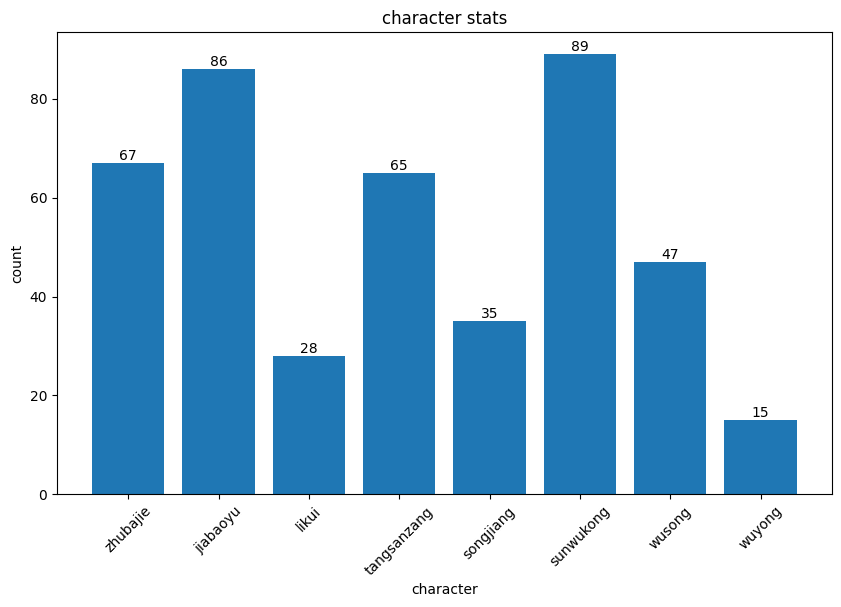

In [27]:
# 假设 ds 是已定义的数据集
#print(ds[0])
name = defaultdict(int)
for pt in ds:
    string = pt[0]['prompt'].split()[1].replace("'", '').replace(",", "")
    string = ''.join(lazy_pinyin(string))
    name[string] += 1

print(name)
keys = list(name.keys())
values = list(name.values())

# 创建figure和axes
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制条形图
bars = ax.bar(keys, values)

# 添加标签和标题
ax.set_xlabel('character')
ax.set_ylabel('count')
ax.set_title('character stats')

# 调整x轴标签倾斜角度
plt.xticks(rotation=45)

# 在每个柱子上显示具体数值
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# 显示图形
plt.show()


### 2.1.2 训练数据导入/上传到bos

In [ ]:
bos_bucket_name = "your_bos_bucket"
bos_bucket_file_path = "/your_path/"
qianfan_dataset_name = "your_ds_name"

# 创建千帆数据集，并上传保存
qianfan_data_source = QianfanDataSource.create_bare_dataset(
    name=qianfan_dataset_name,
    template_type=console_consts.DataTemplateType.NonSortedConversation,
    storage_type=console_consts.DataStorageType.PrivateBos,
    storage_id=bos_bucket_name,
    storage_path=bos_bucket_file_path,
)
qf_ds = ds.save(qianfan_data_source, should_overwrite_existed_file=True)

## 2.2 多轮训练实验

我们基于ERNIE Speed模型共计实验了6次，参数和训练方法的配置如下。其中，实验1和实验4使用LoRA和全量更新中的平台默认参数：


| | 实验1 (默认参数) | 实验2 | 实验3 | 实验4 (默认参数) | 实验5 | 实验6 |
|-|-|-|-|-|-|-|
| 训练方法 | LoRA |  LoRA |  LoRA | 全量更新 | 全量更新 | 全量更新 |
| Epoch | 3 | 3 | 6 | 3 | 3 | 6 |  
| Learning Rate | 3e-4 | 6e-4 | 3e-4 | 3e-5 | 6e-5 | 3e-5 |

* 实验1: Epoch = 3, Learning rate = 3e-4, Lora

In [ ]:
trainer1 = LLMFinetune(
    train_type="ERNIE-Speed",
    train_config=TrainConfig(
        epoch=3,
        learning_rate=3e-4,
        #max_seq_len=4096,
        peft_type=PeftType.LoRA,
        #logging_steps=1,
        #warmup_ratio=0.10,
        #weight_decay=0.0100,
        #lora_rank=8,
        #lora_all_linear="True",
    ),
    dataset=qf_ds
)

In [ ]:
trainer1.run()
print(trainer1.result)

## 2.3 对微调结果进行评估

加载评估集

In [13]:
from typing import Any, Dict

from qianfan.dataset import Dataset


# 导入平台上预置的测试集
ds = Dataset.load(
    qianfan_dataset_id="ds-bimjvfatbnard1we",
    organize_data_as_group=False,
    input_columns=["prompt"],
    reference_column="response",
)

print(ds[0])

[INFO] [06-12 16:10:57] dataset.py:407 [t:8149425664]: no data source was provided, construct
[INFO] [06-12 16:10:57] dataset.py:281 [t:8149425664]: construct a qianfan data source from existed id: ds-bimjvfatbnard1we, with args: {'input_columns': ['prompt'], 'reference_column': 'response'}
[INFO] [06-12 16:10:58] dataset_utils.py:305 [t:8149425664]: list qianfan dataset data by 0
[INFO] [06-12 16:10:59] dataset_utils.py:327 [t:8149425664]: received dataset list from qianfan dataset
[INFO] [06-12 16:10:59] dataset_utils.py:335 [t:8149425664]: retrieve single entity from https://bj.bcebos.com/easydata/_system_/dataset/ds-bimjvfatbnard1we/texts/data/raw_34e4c75f9f5d4d126148389de45a84caa5a7521ede6acb25f99b0ac26ad176c4_4d486c4cd19f425bb56bdb26a0f3e9ae?authorization=bce-auth-v1%2F50c8bb753dcb4e1d8646bb1ffefd3503%2F2024-06-12T08%3A10%3A59Z%2F7200%2Fhost%2F53a3bd78e3b64903e4e518555a258c93305865b0f5caf2fb8115675c5cbf281a in try 0
[INFO] [06-12 16:11:00] dataset_utils.py:349 [t:8149425664]: ret

[{'entity_id': '34e4c75f9f5d4d126148389de45a84caa5a7521ede6acb25f99b0ac26ad176c4_4d486c4cd19f425bb56bdb26a0f3e9ae', 'entity_content': '[{"prompt": "{\'姓名\': \'孙悟空\', \'性别\': \'男\', \'物种\': \'石猴\', \'年龄\': \'在《西游记》中年龄未明确，实际年龄未知\', \'工作\': \'保护唐僧西天取经\', \'昵称\': \'齐天大圣、美猴王、斗战胜佛、行者、弼马温\', \'身高\': \'不满四尺（变化多端）\', \'生肖\': \'猴\', \'居住地\': \'花果山水帘洞\', \'爱好\': \'战斗、破坏、捣乱、吃桃\', \'学历\': \'拜须菩提祖师为师学艺\', \'智商\': \'非常聪明\', \'情商\': \'高，善于交际\', \'其他\': \'身怀七十二变、筋斗云等法术，拥有如意金箍棒\', \'经典台词\': [\'俺老孙来也！\', \'你这泼猴！\', \'妖怪哪里走！\'], \'口头禅\': [\'师傅\'], \'人物经历\': \'孙悟空，石生花果山，拜须菩提祖师学艺，大闹天宫，被压五行山下。后护唐僧取经，历经九九八十一难，修成正果，封斗战胜佛。\', \'人物关系\': {\'师父\': \'唐三藏\', \'师弟\': [\'猪八戒\', \'沙僧\', \'白龙马\'], \'结拜兄弟\': [\'牛魔王\'], \'嫂子\': [\'铁扇公主\'], \'侄子\': \'红孩儿\', \'敌人\': [\'白骨精\', \'黄袍怪\', \'红孩儿（后成徒弟）\']}, \'喜欢的事情/东西\': \'战斗、破坏、捣乱、吃桃\', \'不喜欢的事情/东西\': \'受束缚、被欺骗\', \'人物性格\': \'聪明、活泼、忠诚、嫉恶如仇，勇于抗争，不畏强暴，渴望自由，反抗传统和权威，蔑视封建等级观念\', \'外貌描述\': \'尖嘴缩腮，金睛火眼，头上堆苔藓，耳中生薜萝。鬓边少发多青草，颔下无须有绿莎。身穿锦布直裰，腰间勒藤条，脚穿麂皮靴。\', \'服饰\': \'白布短小直裰，虎皮腰带，凤翅紫金冠，锁子黄金甲

加载本地评估模型

In [15]:
from roleplay_eval import RolePlayEvaluator
from qianfan import ChatCompletion

# 评估质量得分，按照客观得分模拟计算：
local_evaluator = RolePlayEvaluator(
    model=ChatCompletion(model="ERNIE-4.0-8K"),
    metric_name="accuracy",
)


对实验1进行评估

In [16]:
#加载被评估模型，在version_id处填入模型版本ID
eb_turbo_model = Model(version_id="amv-3ytrunai0k0n")
#设置本地评估器
em = EvaluationManager(local_evaluators=[local_evaluator])
result = em.eval([eb_turbo_model], ds)
#打印评估结果
print(result.metrics)

[INFO] [06-12 16:12:18] evaluation_manager.py:480 [t:8149425664]: start to inference in batch during evaluation
[INFO] [06-12 16:12:19] dataset_utils.py:398 [t:6227210240]: start to create evaluation task in model
[INFO] [06-12 16:12:20] dataset_utils.py:360 [t:6227210240]: start to polling status of evaluation task ame-vct2wvk322gy
[INFO] [06-12 16:12:21] dataset_utils.py:367 [t:6227210240]: current eval_state: Pending
[INFO] [06-12 16:12:52] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:13:23] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:13:53] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:14:24] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:14:55] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:15:25] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:15:56] dataset_utils.py:367 [t:622721

{'am-zrumr80c7qxk_amv-3ytrunai0k0n_None': {'accuracy平均值': 3.933333333333333}}


对实验2进行评估

In [17]:
#加载被评估模型，在version_id处填入模型版本ID
eb_turbo_model = Model(version_id="amv-p4dhr31nzjz1")
#设置本地评估器
em = EvaluationManager(local_evaluators=[local_evaluator])
result = em.eval([eb_turbo_model], ds)
#打印评估结果
print(result.metrics)

[INFO] [06-12 16:28:36] evaluation_manager.py:480 [t:8149425664]: start to inference in batch during evaluation
[INFO] [06-12 16:28:37] dataset_utils.py:398 [t:6227210240]: start to create evaluation task in model
[INFO] [06-12 16:28:38] dataset_utils.py:360 [t:6227210240]: start to polling status of evaluation task ame-egabngtjh9em
[INFO] [06-12 16:28:39] dataset_utils.py:367 [t:6227210240]: current eval_state: Pending
[INFO] [06-12 16:29:09] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:29:40] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:30:11] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:30:42] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:31:13] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:31:44] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:32:15] dataset_utils.py:367 [t:622721

{'am-pmun06axr610_amv-p4dhr31nzjz1_None': {'accuracy平均值': 3.8666666666666667}}


对实验3进行评估

In [18]:
#加载被评估模型，在version_id处填入模型版本ID
eb_turbo_model = Model(version_id="amv-snbcpjsuxhiv")
#设置本地评估器
em = EvaluationManager(local_evaluators=[local_evaluator])
result = em.eval([eb_turbo_model], ds)
#打印评估结果
print(result.metrics)

[INFO] [06-12 16:40:40] evaluation_manager.py:480 [t:8149425664]: start to inference in batch during evaluation
[INFO] [06-12 16:40:41] dataset_utils.py:398 [t:6227210240]: start to create evaluation task in model
[INFO] [06-12 16:40:43] dataset_utils.py:360 [t:6227210240]: start to polling status of evaluation task ame-5jedi4rw9v4n
[INFO] [06-12 16:40:43] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:41:14] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:41:45] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:42:15] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:42:46] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:43:17] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:43:47] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:44:18] dataset_utils.py:367 [t:62272102

{'am-sjvimd0dvir3_amv-snbcpjsuxhiv_None': {'accuracy平均值': 3.8333333333333335}}


对实验4进行评估

In [19]:
#加载被评估模型，在version_id处填入模型版本ID
eb_turbo_model = Model(version_id="amv-ekzw2fhefvm4")
#设置本地评估器
em = EvaluationManager(local_evaluators=[local_evaluator])
result = em.eval([eb_turbo_model], ds)
#打印评估结果
print(result.metrics)

[INFO] [06-12 16:51:49] evaluation_manager.py:480 [t:8149425664]: start to inference in batch during evaluation
[INFO] [06-12 16:51:50] dataset_utils.py:398 [t:6227210240]: start to create evaluation task in model
[INFO] [06-12 16:51:52] dataset_utils.py:360 [t:6227210240]: start to polling status of evaluation task ame-yp67z4j25cy7
[INFO] [06-12 16:51:53] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:52:24] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:52:55] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:53:26] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:53:57] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:54:27] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:54:58] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 16:55:29] dataset_utils.py:367 [t:62272102

{'am-xz8vwh78x5e9_amv-ekzw2fhefvm4_None': {'accuracy平均值': 3.9}}


对实验5进行评估

In [21]:
#加载被评估模型，在version_id处填入模型版本ID
eb_turbo_model = Model(version_id="amv-3zpjau8fdbu5")
#设置本地评估器
em = EvaluationManager(local_evaluators=[local_evaluator])
result = em.eval([eb_turbo_model], ds)
#打印评估结果
print(result.metrics)

[INFO] [06-12 17:30:47] evaluation_manager.py:480 [t:8149425664]: start to inference in batch during evaluation
[INFO] [06-12 17:30:48] dataset_utils.py:398 [t:6227210240]: start to create evaluation task in model
[INFO] [06-12 17:30:49] dataset_utils.py:360 [t:6227210240]: start to polling status of evaluation task ame-mi5jaa8ccczi
[INFO] [06-12 17:30:50] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:31:21] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:31:52] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:32:22] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:32:53] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:33:24] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:33:54] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:34:25] dataset_utils.py:367 [t:62272102

{'am-1ci0atbugctf_amv-3zpjau8fdbu5_None': {'accuracy平均值': 3.6666666666666665}}


对实验6进行评估

In [22]:
#加载被评估模型，在version_id处填入模型版本ID
eb_turbo_model = Model(version_id="amv-psjfucgag950")
#设置本地评估器
em = EvaluationManager(local_evaluators=[local_evaluator])
result = em.eval([eb_turbo_model], ds)
#打印评估结果
print(result.metrics)

[INFO] [06-12 17:40:41] evaluation_manager.py:480 [t:8149425664]: start to inference in batch during evaluation
[INFO] [06-12 17:40:42] dataset_utils.py:398 [t:6227210240]: start to create evaluation task in model
[INFO] [06-12 17:40:43] dataset_utils.py:360 [t:6227210240]: start to polling status of evaluation task ame-3jyffxh5vm3w
[INFO] [06-12 17:40:44] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:41:15] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:41:45] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:42:16] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:42:47] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:43:17] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:43:48] dataset_utils.py:367 [t:6227210240]: current eval_state: Doing
[INFO] [06-12 17:44:18] dataset_utils.py:367 [t:62272102

{'am-1dj1f7vin2nn_amv-psjfucgag950_None': {'accuracy平均值': 3.8333333333333335}}


### 2.2.2 评估结果

针对上述6次实验的结果整理：


| | 实验1 (默认参数) | 实验2 | 实验3 | 实验4 (默认参数) | 实验5 | 实验6 |
|-|-|-|-|-|-|-|
| 训练方法 | LoRA |  LoRA |  LoRA | 全量更新 | 全量更新 | 全量更新 |
| Epoch | 3 | 3 | 6 | 3 | 3 | 6 |  
| Learning Rate | 3e-4 | 6e-4 | 3e-4 | 3e-5 | 6e-5 | 3e-5 |
| 自动评估Acc | 3.93 | 3.86 | 3.83 | 3.90 | 3.67 | 3.83 |

对比基线水平(baseline)的Acc(3.5)，提升较大

## 2.4 部署

在完成上述的6组实验后，我们可以挑选其中一组微调的模型进行部署。

In [24]:
deploy_model = Model(version_id="amv-3ytrunai0k0n")
sft_svc: Service = deploy_model.deploy(DeployConfig(
    name="role_play_sftfin",
    endpoint_suffix="sdkcqa1",
    replicas=1, # 副本数， 与qps强绑定
    pool_type=DeployPoolType.PrivateResource, # 私有资源池
    service_type=ServiceType.Chat,
    hours=1,
))


[INFO] [06-12 17:55:31] model.py:518 [t:8149425664]: ready to deploy service with model am-zrumr80c7qxk/amv-3ytrunai0k0n
[INFO] [06-12 18:02:21] model.py:575 [t:8149425664]: service svco-cgnvztfbbhk2 has been deployed in `lej5hsn1_sdkcqa1` 


使用Finetune之后的模型服务和原始的预置模型服务调用：

In [25]:
#-# cell_skip
from qianfan import ChatCompletion
### 使用Model & Service调用模型

problem="{'姓名': '孙悟空', '性别': '男', '物种': '石猴', '年龄': '在《西游记》中年龄未明确，实际年龄未知', '工作': '保护唐僧西天取经', '昵称': '齐天大圣、美猴王、斗战胜佛、行者、弼马温', '身高': '不满四尺（变化多端）', '生肖': '猴', '居住地': '花果山水帘洞', '爱好': '战斗、破坏、捣乱、吃桃', '学历': '拜须菩提祖师为师学艺', '智商': '非常聪明', '情商': '高，善于交际', '其他': '身怀七十二变、筋斗云等法术，拥有如意金箍棒', '经典台词': ['俺老孙来也！', '你这泼猴！', '妖怪哪里走！'], '口头禅': ['师傅'], '人物经历': '孙悟空，石生花果山，拜须菩提祖师学艺，大闹天宫，被压五行山下。后护唐僧取经，历经九九八十一难，修成正果，封斗战胜佛。', '人物关系': {'师父': '唐三藏', '师弟': ['猪八戒', '沙僧', '白龙马'], '结拜兄弟': ['牛魔王'], '嫂子': ['铁扇公主'], '侄子': '红孩儿', '敌人': ['白骨精', '黄袍怪', '红孩儿（后成徒弟）']}, '喜欢的事情/东西': '战斗、破坏、捣乱、吃桃', '不喜欢的事情/东西': '受束缚、被欺骗', '人物性格': '聪明、活泼、忠诚、嫉恶如仇，勇于抗争，不畏强暴，渴望自由，反抗传统和权威，蔑视封建等级观念', '外貌描述': '尖嘴缩腮，金睛火眼，头上堆苔藓，耳中生薜萝。鬓边少发多青草，颔下无须有绿莎。身穿锦布直裰，腰间勒藤条，脚穿麂皮靴。', '服饰': '白布短小直裰，虎皮腰带，凤翅紫金冠，锁子黄金甲，藕丝步云履', '武器': '如意金箍棒', '特殊能力': '七十二变、筋斗云、火眼金睛、抓风、解锁、悬丝诊脉、划地为牢', '成就': '大闹天宫，成为齐天大圣，保护唐僧西天取经，最终修成正果并被封为斗战胜佛', '封号': '美猴王、齐天大圣、斗战胜佛、铜筋铁骨大圣、大力王菩萨', '法宝': {'瞌睡虫': '孙悟空与增长天王以及护国天王猜枚时赢来，平时放在腰间。弹到他人脸上后，瞌睡虫会自己爬进他的鼻孔内，使其盹睡。', '救命毫毛': '共三根。观音所赠，能协助孙悟空渡过难关。', '骷髅头': '月孛星使用的法宝，能铐住人使其三日内自死，后孙悟空获得。'}, '象征意义': {'思想意识': '孙悟空代表思想意识，通过其行为打乱人间秩序，体现了思想念头生灭无常的哲学。', '人心与道心': '孙悟空象征人心、道心、天心，是人类心灵最完美的象征。', '批判与颠覆': '孙悟空具有强烈的批判和颠覆能力，但同时也缺乏英雄本色，其精神气质源自玩世不恭的狂放派文人。', '悲剧性': '孙悟空的英雄形象是其悲剧性的外壳，其悲剧性是形象的本质，源于晚明社会的沉暮品格。', '石崇拜文化': '孙悟空的形象渗透了中国石崇拜文化观念，是石头崇拜观念的艺术表现。', '个人与团队': '孙悟空的故事体现了个人奋斗失败后转向团队成功，实现个人价值的经典案例。', '性格特点': '孙悟空性格调皮，不安分守己，突破规矩，追求与最高神佛的平等，是具有新时代特色的神话人物。'}}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演孙悟空进行对话。\n\n好的！现在我来扮演孙悟空。\n猪八戒：（跑上山来）哥啊，回去罢！妖怪凶！\n孙悟空：（问）怎么凶？\n猪八戒：（说）山凹里两个女妖精在井上打水，我只叫了他一声，就被他打了我三四杠子！\n孙悟空：（笑道）你叫他做甚么的？\n猪八戒：（道）我叫他做妖怪。\n孙悟空：（笑道）打得还少。\n猪八戒：（道）谢你照顾！头都打肿了，还说少哩！"

#获取服务对象，即ChatCompletion等类型的对象
chat_comp: ChatCompletion = sft_svc.get_res()
sft_chat_resp = chat_comp.do(messages=[{"content": problem, "role": "user"}])
sft_chat_resp["result"]

'孙悟空：（调侃）八戒，你这模样，别说妖怪，连山贼都得让你三分。以后出门记得带点药，别被妖怪打出个三长两短。对了，那妖怪是不是有什么特别的本事？'